In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# EDA and Non-NN Models

**This notebook is still a work-in-progress. I will add more documentation on the way. However feel free to check it out, comment etc.**

This months Playground problem is a multiclass-classification task, where models are evaluated on accuracy. In this notebook I am tackling the problem without Neural Networks. I will implement a seperate notebook for that later on. The data is a synthesized version of data about forest cover first mentioned in a paper by Blackard and Dean in 1999. I recommend checking out the paper to gain some insight into the original dataset and to get a nice view of how far ML has come. Their best model has an acc. of ~70% and they utilize wide neural nets, which was quite common in that time.

## Imports

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from sklearn.preprocessing import StandardScaler,RobustScaler,QuantileTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline


from imblearn.over_sampling import SMOTENC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


## Loading the Data

In [ ]:
df_train = pd.read_csv('../input/tabular-playground-series-dec-2021/train.csv')
df_test = pd.read_csv('../input/tabular-playground-series-dec-2021/test.csv')

## Reducing the Memory Usage

This code (except for the docstring) was provided by Luca Massaron in this discussion [thread](https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion/291844)

In [ ]:
def reduce_mem_usage(df, verbose=True):
    """
    Reduce memory usage by downcasting features.
    
    Args:
        df (pd.DataFrame): DataFrame with features.
        verbose (bool): Determines verbosity of output.
    Returns:
        df (pd.DataFrame): DataFrame with reduces memory usage, due to smaller datatypes.
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

In [ ]:
def prep_test_data(df, engineer_features = True):
    """Transforms the test data to match model/pipeline expectations"""
    
    df = df.drop(['Id','Soil_Type7', 'Soil_Type15'], axis = 1)
    if engineer_features:
        df["mean"] = df.mean(axis=1)
        df["std"] = df.std(axis=1)
        df["min"] = df.min(axis=1)
        df["max"] = df.max(axis=1)
    return df

## EDA

General overview.

In [ ]:
df_train.info()

Check for NAs and duplicates.

In [ ]:
df_train.isna().any()

In [ ]:
df_train.duplicated().any()

No duplicates or NAs. Very good.

### Stats overview

In [ ]:
df_train.describe().T

First observations concerning the features:
- Soil_Type7 and Soil_Type15 are always 0. They do not provide information -> drop
- Hillshade should be a pixel value, but there are negatives which shouldn't be possbile. Probably due to the synthetic dataset.
- There are some distance values, those technically shouldn't be < 0 (negative), but they are. Probably due to the synthetic dataset.
- Basically all Soil_Types are mostly 0 with few 1. Meaning they are most not present. These could be strongly differenciating features between classes.

Dropping ID, and Soil_Type7&15

In [ ]:
df_train = df_train.drop(['Id','Soil_Type7','Soil_Type15'], axis = 1)

### Correlation

In [ ]:
fig, ax = plt.subplots(figsize = (15,12))
sns.heatmap(df_train.corr(), ax = ax)

Strong neg correlation between wilderness area 1 and 3 -> possible collinearity? Some small-medium sized correlations between soil types and elevation. Strong correlation between elevation and cover type (expected given the range of elevation and the biology of trees)

### Split Features and Target

In [ ]:
features_train = df_train.drop('Cover_Type', axis = 1)
target_train = df_train['Cover_Type']

In [ ]:
features_plot = features_train.sample(frac = 0.4) #using a subsample to speed up plotting
print(features_plot.shape)
fig, axis = plt.subplots(nrows = 13,ncols = 4, figsize = (20,25))
axis = axis.flatten()

for i,col in enumerate(features_plot):
    sns.boxplot(x = features_plot[col], ax = axis[i])
    axis[i].set_title(col)
fig.tight_layout()

The Soil_Types are very unevenly distributed as noted before. Slope and Distances are left skewed and shades right skewed. Elevation and Aspect look to be close to Normal or T-Distributions.

### Target distribution

In [ ]:
print(df_train['Cover_Type'].value_counts())
fig, ax = plt.subplots(figsize = (10,8))
sns.countplot(x = df_train['Cover_Type'])

The target is not only multiclass but also very imbalanced. Cover_Type 1&2 dominate, 3,6,7 are somewhat frequent, 4 and especially 5 are extremely rare.

## Target Counts for each binary Feature

In [ ]:
binary_cols = features_train.columns[10:]
print(len(binary_cols))

In [ ]:
fig, axis = plt.subplots(nrows = 7,ncols = 6, figsize = (20,25))
axis = axis.flatten()

for i,col in enumerate(binary_cols):
    sns.countplot(x = features_plot[col],hue = target_train, ax = axis[i])
    axis[i].set_title(col)
    sns.despine()
fig.tight_layout()


Some binary features show different distributions for the classes, there are however no very distinct features that for example determine a class completely.

## UMAP

I thought it might help to get a sense of how the different classes are clustered, whether they are all very close to each other or not. I decided to give umap a try.

**WARNING: Cell takes long**

In [ ]:
# features_plot = features_train.sample(frac = 0.2, random_state = 13) #utilizing a reduced set due to memory issues.
# target_plot = target_train.iloc[features_plot.index]

# standard_embedding = umap.UMAP(random_state = 13).fit_transform(features_plot)
# plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=target_plot, s=0.1, cmap='Spectral')

It looks like there aren't clear clusters, at least not with this method. I attached the result so you don't have to run the cell.

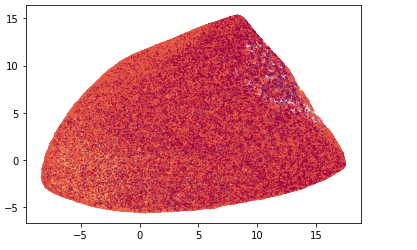

## Baseline Models

Let's start with simple baseline models before feature engineering to get a sense of the accuracy ranges we aim for.

In [ ]:
dt_baseline = DecisionTreeClassifier(random_state = 13)

In [ ]:
cross_val_score(estimator=dt_baseline,
                X=features_train,y=target_train, 
                scoring = 'accuracy', 
                n_jobs = 3, cv = 3, verbose = 1)


The extremely simple baseline model already provides decent accuracy with around 0.94. Let's make it the first submission.

In [ ]:
# dt_baseline.fit(features_train, target_train)
# features_test = prep_test_data(df_test)
# print(features_test.shape)
# preds_baseline  = dt_baseline.predict(features_test)
# df_submission_base = pd.DataFrame({'id': df_test.loc[:,'Id'], 'Cover_Type':preds_baseline})
# print(df_submission_base.head())
# df_submission_base.to_csv('submission.csv', index = None)

In [ ]:
rf_baseline = RandomForestClassifier(n_estimators = 25, random_state = 13, n_jobs = -1)
cross_val_score(estimator = rf_baseline,
                X=features_train,y=target_train, 
                scoring = 'accuracy', 
                n_jobs = 3, cv = 3, verbose = 1)

Random Forest Baseline does a bit better than the Decision Tree which was expected. Let's make another submission.

In [ ]:
# rf_baseline = RandomForestClassifier(n_estimators = 50, random_state = 13, n_jobs = -1)
# rf_baseline.fit(features_train, target_train)
# features_test = prep_test_data(df_test)
# print(features_test.shape)
# preds_baseline_rf  = rf_baseline.predict(features_test)
# df_submission_base_rf = pd.DataFrame({'id': df_test.loc[:,'Id'], 'Cover_Type':preds_baseline_rf})
# print(df_submission_base_rf.head())
# df_submission_base_rf.to_csv('submission.csv', index = None) 

This submission score 0.9498. Not bad given that the model wasn't tuned nor any feature engineering done.

## Basic Feature Engineering

The most basic feature engineering is to use summary statistics of the data as a feature. Let's try it and see if this changes baseline performance at all.

In [ ]:
features_train["mean"] = features_train.mean(axis=1)
features_train["std"] = features_train.std(axis=1)
features_train["min"] = features_train.min(axis=1)
features_train["max"] = features_train.max(axis=1)

In [ ]:
#features_train.drop(['mean', 'std', 'min', 'max'], axis = 1, inplace = True) #in case the summary stats don't work well

In [ ]:
rf_baseline = RandomForestClassifier(n_estimators = 25, random_state = 13, n_jobs = -1)
cross_val_score(estimator = rf_baseline,
                X=features_train,y=target_train, 
                scoring = 'accuracy', 
                n_jobs = 3, cv = 3, verbose = 1)

The additional features didn't move performance much in either direction.

## Adressing class imbalances

I am using SMOTENC here. However, due to the size of the dataset I am running into memory issues. I decided to only use SMOTENC on a fraction of the data,oversampling the class with only few samples. I am however dropping the class with only one sample.

In [ ]:
binary_cols_idx = [features_train.columns.get_loc(binary_col) for binary_col in binary_cols]
minority_class_target = target_train[target_train == 5]
minority_class_feat = features_train.loc[minority_class_target.index,:]

In [ ]:
features_train = features_train.drop(minority_class_target.index, axis = 0)
target_train = target_train.drop(minority_class_target.index, axis = 0)

In [ ]:
sm = SMOTENC(random_state = 13, categorical_features = binary_cols_idx, sampling_strategy = 'minority')

In [ ]:
features_train_resample = features_train.sample(frac = 0.05)
target_train_resample = target_train[features_train_resample.index]

In [ ]:
features_train_smote, target_train_smote = sm.fit_resample(features_train_resample, target_train_resample)

In [ ]:
# drop the sampled data to re-add resampled
features_train = features_train.drop(features_train_resample.index, axis = 0)
target_train = target_train.drop(target_train_resample.index, axis = 0)
features_train.append(features_train_smote, ignore_index = True)
target_train.append(target_train_smote, ignore_index = True)

In [ ]:
features_train.shape, target_train.shape

## Scaling

As most models don't do well with unscaled data I will use a RobustScaler (due to some features showing outliers) to prepare the data. Only the Random Forest will be trained on the unscaled data.

In [ ]:
scaler = RobustScaler()
features_train_unscaled = features_train.copy()
features_train = scaler.fit_transform(features_train)

In [ ]:
target_train = target_train.to_numpy()

## CatBoost



In [ ]:
model = CatBoostClassifier(objective = 'MultiClass', task_type = 'GPU')

catboost_scores = []
kf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 13)
for fold, (train_idx, valid_idx) in enumerate(kf.split(X = features_train, y = target_train)):

    print(f"Fold {fold + 1}")
    features_train_fold = features_train[train_idx, :]
    features_valid_fold = features_train[valid_idx, :]
    target_train_fold = target_train[train_idx]
    target_valid_fold = target_train[valid_idx]
    
    model.fit(features_train_fold, target_train_fold,
          early_stopping_rounds = 200,
          eval_set = [(features_valid_fold, target_valid_fold)],
          verbose = 0)
    
    preds_valid = model.predict(features_valid_fold)
    acc = accuracy_score(target_valid_fold,  preds_valid)
    catboost_scores.append(acc)
    print(f"Fold {fold + 1}, acc: {acc:.5f}")
    
print("Mean Accuracy:", np.mean(catboost_scores))

This looks pretty promising. I am submitting the models predictions.

In [ ]:
model = CatBoostClassifier(objective = 'MultiClass', task_type = 'GPU')
model.fit(features_train, target_train,
          early_stopping_rounds = 200,
          verbose = 0)

#prep test data
features_test = prep_test_data(df_test)
features_test = scaler.transform(features_test)

preds_catboost  = model.predict(features_test)


In [ ]:
df_submission_catboost = pd.DataFrame({'id': df_test.loc[:,'Id'], 'Cover_Type': preds_catboost.flatten()})
print(df_submission_catboost.head())
df_submission_catboost.to_csv('submission.csv', index = None) 

## XGBoost

In [ ]:
model = XGBClassifier(objective = 'multi:softmax', 
                      eval_metric = 'mlogloss', 
                      tree_method = 'gpu_hist', 
                      predictor = 'gpu_predictor')

xgb_scores = []
kf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 13)
for fold, (train_idx, valid_idx) in enumerate(kf.split(X = features_train, y = target_train)):

    print(f"Fold {fold + 1}")
    features_train_fold = features_train[train_idx, :]
    features_valid_fold = features_train[valid_idx, :]
    target_train_fold = target_train[train_idx]
    target_valid_fold = target_train[valid_idx]
    
    model.fit(features_train_fold, target_train_fold,
          early_stopping_rounds = 200,
          eval_set = [(features_valid_fold, target_valid_fold)],
          verbose = 0)
    
    preds_valid = model.predict(features_valid_fold)
    acc = accuracy_score(target_valid_fold,  preds_valid)
    xgb_scores.append(acc)
    print(f"Fold {fold + 1}, acc: {acc:.5f}")
    
print("Mean Accuracy:", np.mean(xgb_scores))

XGBoost also reaches very good performance and works much faster than CatBoost.
I will also submit it's predictions and consider it for a voting classifier.

In [ ]:
model = XGBClassifier(objective = 'multi:softmax', 
                      eval_metric = 'mlogloss', 
                      tree_method = 'gpu_hist', 
                      predictor = 'gpu_predictor')
model.fit(features_train, target_train,
          verbose = 0)

#prep test data
features_test = prep_test_data(df_test)
features_test = scaler.transform(features_test)

preds_xgb  = model.predict(features_test)
df_submission_xgb = pd.DataFrame({'id': df_test.loc[:,'Id'], 'Cover_Type': preds_xgb.flatten()})
print(df_submission_xgb.head())
df_submission_xgb.to_csv('submission_xgb.csv', index = None) 

In [ ]:
print(preds_xgb)

## Tuned Random Forest

In [ ]:
# rf_clf = RandomForestClassifier(n_estimators = 50, random_state = 13, n_jobs = -1)
# rf_searchspace = {'max_depth':[None, 5,  15],
#                   'min_samples_split': [2,4,6,8,10],
#                   'min_samples_leaf': [1,2],
#                   'max_features': ['auto','log2'],
#                   'bootstrap': [False, True],
#                   'class_weight': ['balanced', None]}
# search_cv = RandomizedSearchCV(estimator = rf_clf, 
#                                param_distributions = rf_searchspace, 
#                                cv = 3,
#                                scoring = 'accuracy',
#                                n_iter = 15,
#                                verbose = 1,
#                                n_jobs = 2
#                               )
# search_cv.fit(features_train_unscaled,target_train)
# print(search_cv.best_score_)
# print(search_cv.best_estimator_)

## Voting Classifier

I intend to combine the Random Forest, CatBoost and maybe others to see if they work even better together.

I already found out that CatBoost doesn't work well in the VotingClassifier from sklearn due to the shape of predictions. This can be solved by Subclassing the CatBoost model to change the outputs.

In [ ]:
class CatBoostClassifierInt(CatBoostClassifier):
    def predict(self, data, prediction_type='Class', ntree_start=0, ntree_end=0, thread_count=1, verbose=None, task_type="CPU"):
        predictions = self._predict(data, prediction_type, ntree_start, ntree_end, thread_count, verbose, 'predict', task_type)

        # This line is the only change
        return np.asarray(predictions, dtype=np.int64).ravel()

In [ ]:
rf_clf = RandomForestClassifier(n_estimators = 50, random_state = 13, n_jobs = -1)
xgb_clf = XGBClassifier(objective = 'multi:softmax', 
                      eval_metric = 'mlogloss', 
                      tree_method = 'gpu_hist', 
                      predictor = 'gpu_predictor')
catboost_clf = CatBoostClassifierInt(objective = 'MultiClass', 
                                   task_type = 'GPU')

In [ ]:
voting_clf = VotingClassifier(estimators = [('rf', rf_clf), ('xgb', xgb_clf), ('catboost', catboost_clf)])
cross_val_score(estimator = voting_clf,
                X = features_train, y = target_train, 
                scoring = 'accuracy', 
                n_jobs = 1, cv = 3, verbose = 0)

The results are not as good as with just the catboost. I will still submit them as they might generalize better.

In [ ]:
voting_clf.fit(features_train, target_train)
#prep test data
features_test = prep_test_data(df_test)
features_test = scaler.transform(features_test)

preds_voting = voting_clf.predict(features_test)
df_submission_voting = pd.DataFrame({'id': df_test.loc[:,'Id'], 'Cover_Type': preds_voting})
print(df_submission_voting.head())
df_submission_voting.to_csv('submission_voting.csv', index = None) 